In [1]:
# 사용할 라이브러리 호출하기
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
train = np.load('./data/food_filtered_train_224.npz')
val = np.load('./data/food_filtered_val_224.npz')

In [3]:
X_train = train['X_train']
y_train = train['y_train']
X_val = val['X_val']
y_val = val['y_val']

In [4]:
print('훈련용 : ', X_train.shape, y_train.shape)
print('검증용 : ', X_val.shape, y_val.shape)

훈련용 :  (8007, 224, 224, 3) (8007,)
검증용 :  (984, 224, 224, 3) (984,)


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
# include_top = False : 불러온 모델의 mlp층(전결합층, 분류기층)을 사용하지 않음
#                       특성추출부
# weight : imageNet에서 학습된 가중치(w)를 그대로 가져옴
# imageNet : 1000개의 클래스로 분류된 100만장이 넘는 이미지를 담고 있는 데이터셋
vgg16 = VGG16(include_top = False,
              weights = 'imagenet',
              input_shape = (224,224,3))

# VGG16이 가지고 있는 잘 셋팅된 w,b 값을 활용하여 이진 분류를 진행할 수 있다!
# 기존 가중치를 약간 변경할 수 있도록 마지막 cnn층을 학습이 가능하도록 설정할 수 있다!
# VGG모델의 특징 추출부에서 맨 마지막 층만 학습이 되도록 동결된 것을 풀어주자!

# 전이학습 2가지 방법
# 1. 특성 추출 -> 중요한 정보만 뽑아서 배열 데이터로 출력 후 활용
# 2. 미세조정방식 -> 끝부분 합성곱층(conv) 부분을 미세하게 조정하여 학습시키는 방식으로 활용

# 2. 미세조정 방식 진행
for layer in vgg16.layers:
    print(layer.name) # vgg16모델의 층 이름 확인

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [7]:
# 신경망 연결해보기
model = Sequential()

# 미세조정방식 적용해서 vgg16 연결
# ---------------------
# 한 개의 층만 학습 가능하도록 설정, 그 외에 나머지층은 동결시키기
for layer in vgg16.layers:
    # 학습 가능하도록 설정 : block5_conv3
    if layer.name == 'block5_conv3':
        layer.trainable = True
    else: # 학습 불가능하게 설정(동결시키기)
        layer.trainable = False
# ----------------------

# 입력층 정의
model.add(InputLayer(input_shape=(224, 224, 3)))

# 특성추출부 연결
model.add(vgg16)

# 분류기층 필요!
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

# 컴파일
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [8]:
# 모델 체크포인트 정의
# 저장할 폴더 설정
# 언제 저장할지 기준 설정
model_dir= './acc/model_vgg16'

# 만약에 해당 폴더가 없다면 생성
# os.path.exists(model_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# 모델 저장 파일명 설정
# 정규식 표현법{변수명:출력형태}
# {epoch:03d} : epoch 변수값을 가져와서 정수형 3자리로 표시(3자리보다 작으면 왼쪽에 0으로 채운다)
# {accuracy:.2f} : accuracy 값을 가져와서 소수점 2째자리까지 표시 -> val_accuracy
file_path = model_dir + "/food_{epoch:03d}_{val_accuracy:.2f}.hdf5"
f_mckp = ModelCheckpoint(filepath = file_path,
                         monitor = 'val_accuracy',
                         save_best_only = True)

# 조기학습중단 정의
# 언제 중단할지 : patience, 어떤값을 보고 멈출지 기준 설정 : val_accuracy
f_early = EarlyStopping(monitor = 'val_accuracy',
                        patience = 10) # 기다리는 횟수를 설정

# 모든 정의가 끝난 후 fit에 연결

In [9]:
# 학습률 스케줄링
# ReduceLROnPlateau : 검증손실(validation loss)이 개선되지 않을 때 학습률을 동적으로 감소시키는 역할
# monitor: 모니터링 할 지표. 기본값은 'val_loss'입니다.
# factor: 학습률을 감소시키는 비율. 새로운 학습률 = 현재 학습률 * factor. 기본값은 0.1입니다.
# patience: 검증 손실이 개선되지 않은 에포크(epoch) 수. 만약 해당 에포크 수가 지나면 학습률이 감소됩니다. 기본값은 10입니다.
# min_delta: 개선되지 않은 손실의 최소 변화량. 이 값을 넘어야 손실이 개선되지 않은 것으로 간주됩니다. 기본값은 1e-4입니다.
# cooldown: 학습률 감소 후 다시 정상적인 학습을 재개하는데 걸리는 에포크 수. 기본값은 0입니다.
# verbose: 로그 출력 레벨. 0, 1, 2 중 하나를 선택할 수 있습니다. 기본값은 0입니다.
# min_lr: 학습률의 하한값. 더 이상 학습률을 줄일 수 없을 때 적용됩니다. 기본값은 0입니다.
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=7)

In [10]:
h1 = model.fit(X_train, y_train,
                        validation_data = (X_val, y_val),
                        batch_size= 64,
                        epochs = 100,
                        callbacks = [f_mckp, f_early, reduce_lr]) # 모델 체크포인트, 조기합습중단 연결

Epoch 1/100
126/126 [==============================] - 34s 192ms/step - loss: 2.0236 - accuracy: 0.4537 - val_loss: 1.0903 - val_accuracy: 0.5589
Epoch 2/100
126/126 [==============================] - 21s 170ms/step - loss: 0.8129 - accuracy: 0.6770 - val_loss: 0.9174 - val_accuracy: 0.6931
Epoch 3/100
126/126 [==============================] - 21s 169ms/step - loss: 0.5108 - accuracy: 0.8122 - val_loss: 0.8539 - val_accuracy: 0.7276
Epoch 4/100
126/126 [==============================] - 21s 169ms/step - loss: 0.2968 - accuracy: 0.8912 - val_loss: 0.8021 - val_accuracy: 0.7663
Epoch 5/100
126/126 [==============================] - 21s 170ms/step - loss: 0.1667 - accuracy: 0.9418 - val_loss: 0.7788 - val_accuracy: 0.7764
Epoch 6/100
126/126 [==============================] - 21s 170ms/step - loss: 0.0982 - accuracy: 0.9675 - val_loss: 0.7328 - val_accuracy: 0.7846
Epoch 7/100
126/126 [==============================] - 22s 171ms/step - loss: 0.0546 - accuracy: 0.9816 - val_loss: 0.8453 -

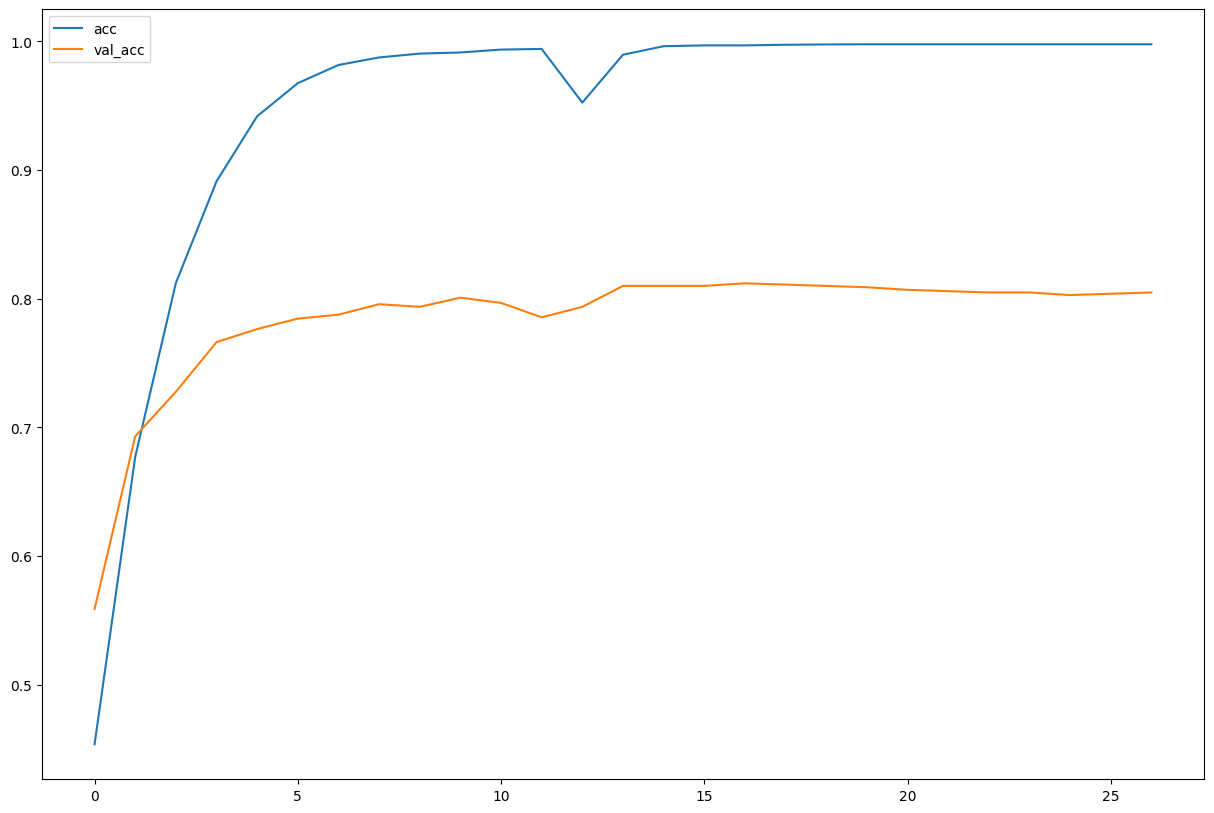

In [11]:
plt.figure(figsize=(15,10))
plt.plot(h1.history['accuracy'], label='acc')
plt.plot(h1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()